In [1]:
from epimodel import EpidemiologicalParameters, DefaultModel, preprocess_data
from epimodel.pymc3_models.base_model import produce_CIs, add_cms_to_plot

import numpy as np
import pymc3 as pm
import pickle
import os

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
%matplotlib inline

Set Theano Environmental Variables for Parallelisation


In [2]:
data = preprocess_data('../../merged_data/double_entry_final.csv', last_day='2020-05-30', smoothing=1)

Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Masking invalid values


In [3]:
def month_to_str(x):
    if x == 1:
        return "JAN"
    if x == 2:
        return "FEB"
    if x == 3:
        return "MAR"
    if x == 4:
        return "APR"
    if x == 5:
        return "MAY"

cols = sns.cubehelix_palette(3, start=0.2, light=0.6, dark=0.1, rot=0.2)
cm_plot_style = [
            ("\uf963", "black"), # mask
            ("\uf0c0", cols[0]), # ppl
            ("\uf0c0", cols[1]), # ppl
            ("\uf0c0", cols[2]), # ppl
            ("\uf07a", cols[0]), # shop 1
            ("\uf07a", cols[2]), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]


class ResultsObject():
    def __init__(self, indx, trace):
        self.CMReduction = trace.CMReduction
        self.RegionR = trace.RegionR[:, indx]
        self.InfectedCases = trace.InfectedCases[:, indx, :]
        self.InfectedDeaths = trace.InfectedDeaths[:, indx, :]
        self.ExpectedCases = trace.ExpectedCases[:, indx, :]
        self.ExpectedDeaths = trace.ExpectedDeaths[:, indx, :]
        self.PsiCases = trace.PsiCases
        self.PsiDeaths = trace.PsiDeaths

In [64]:
from scipy.stats import nbinom

def sample_cases_region(mdir, rg, data):
    # assume data.mask_reopenings() has already been called
    
    r_i = data.Rs.index(rg)
    cases_start, deaths_start = data.mask_region(rg)
    try:   
        res = pickle.load(open(os.path.join(mdir, f"{rg}.pkl"), "rb"))

        ec = res.ExpectedCases
        nS, nDs_c = ec.shape

        alpha = np.repeat(res.PsiCases.reshape(nS, 1), 130, axis = -1)     
        p = alpha / (alpha + ec)

        return nbinom.rvs(alpha, p)
    except Exception as e:
        print(e)
        return 10**-10*np.ones((1000, 130))
        
def sample_deaths_region(mdir, rg, data):
    # assume data.mask_reopenings() has already been called
    r_i = data.Rs.index(rg)
    cases_start, deaths_start = data.mask_region(rg)

    try:   
        res = pickle.load(open(os.path.join(mdir, f"{rg}.pkl"), "rb"))
        ed = res.ExpectedDeaths
        nS, nDs_d = ed.shape
    
        alpha = np.repeat(res.PsiDeaths.reshape(nS, 1), 130, axis = -1)     
        p = alpha / (alpha + ed)
        return nbinom.rvs(alpha, p)
    except Exception as e:
        print(e)
        return 10**-10*np.ones((1000, 130))


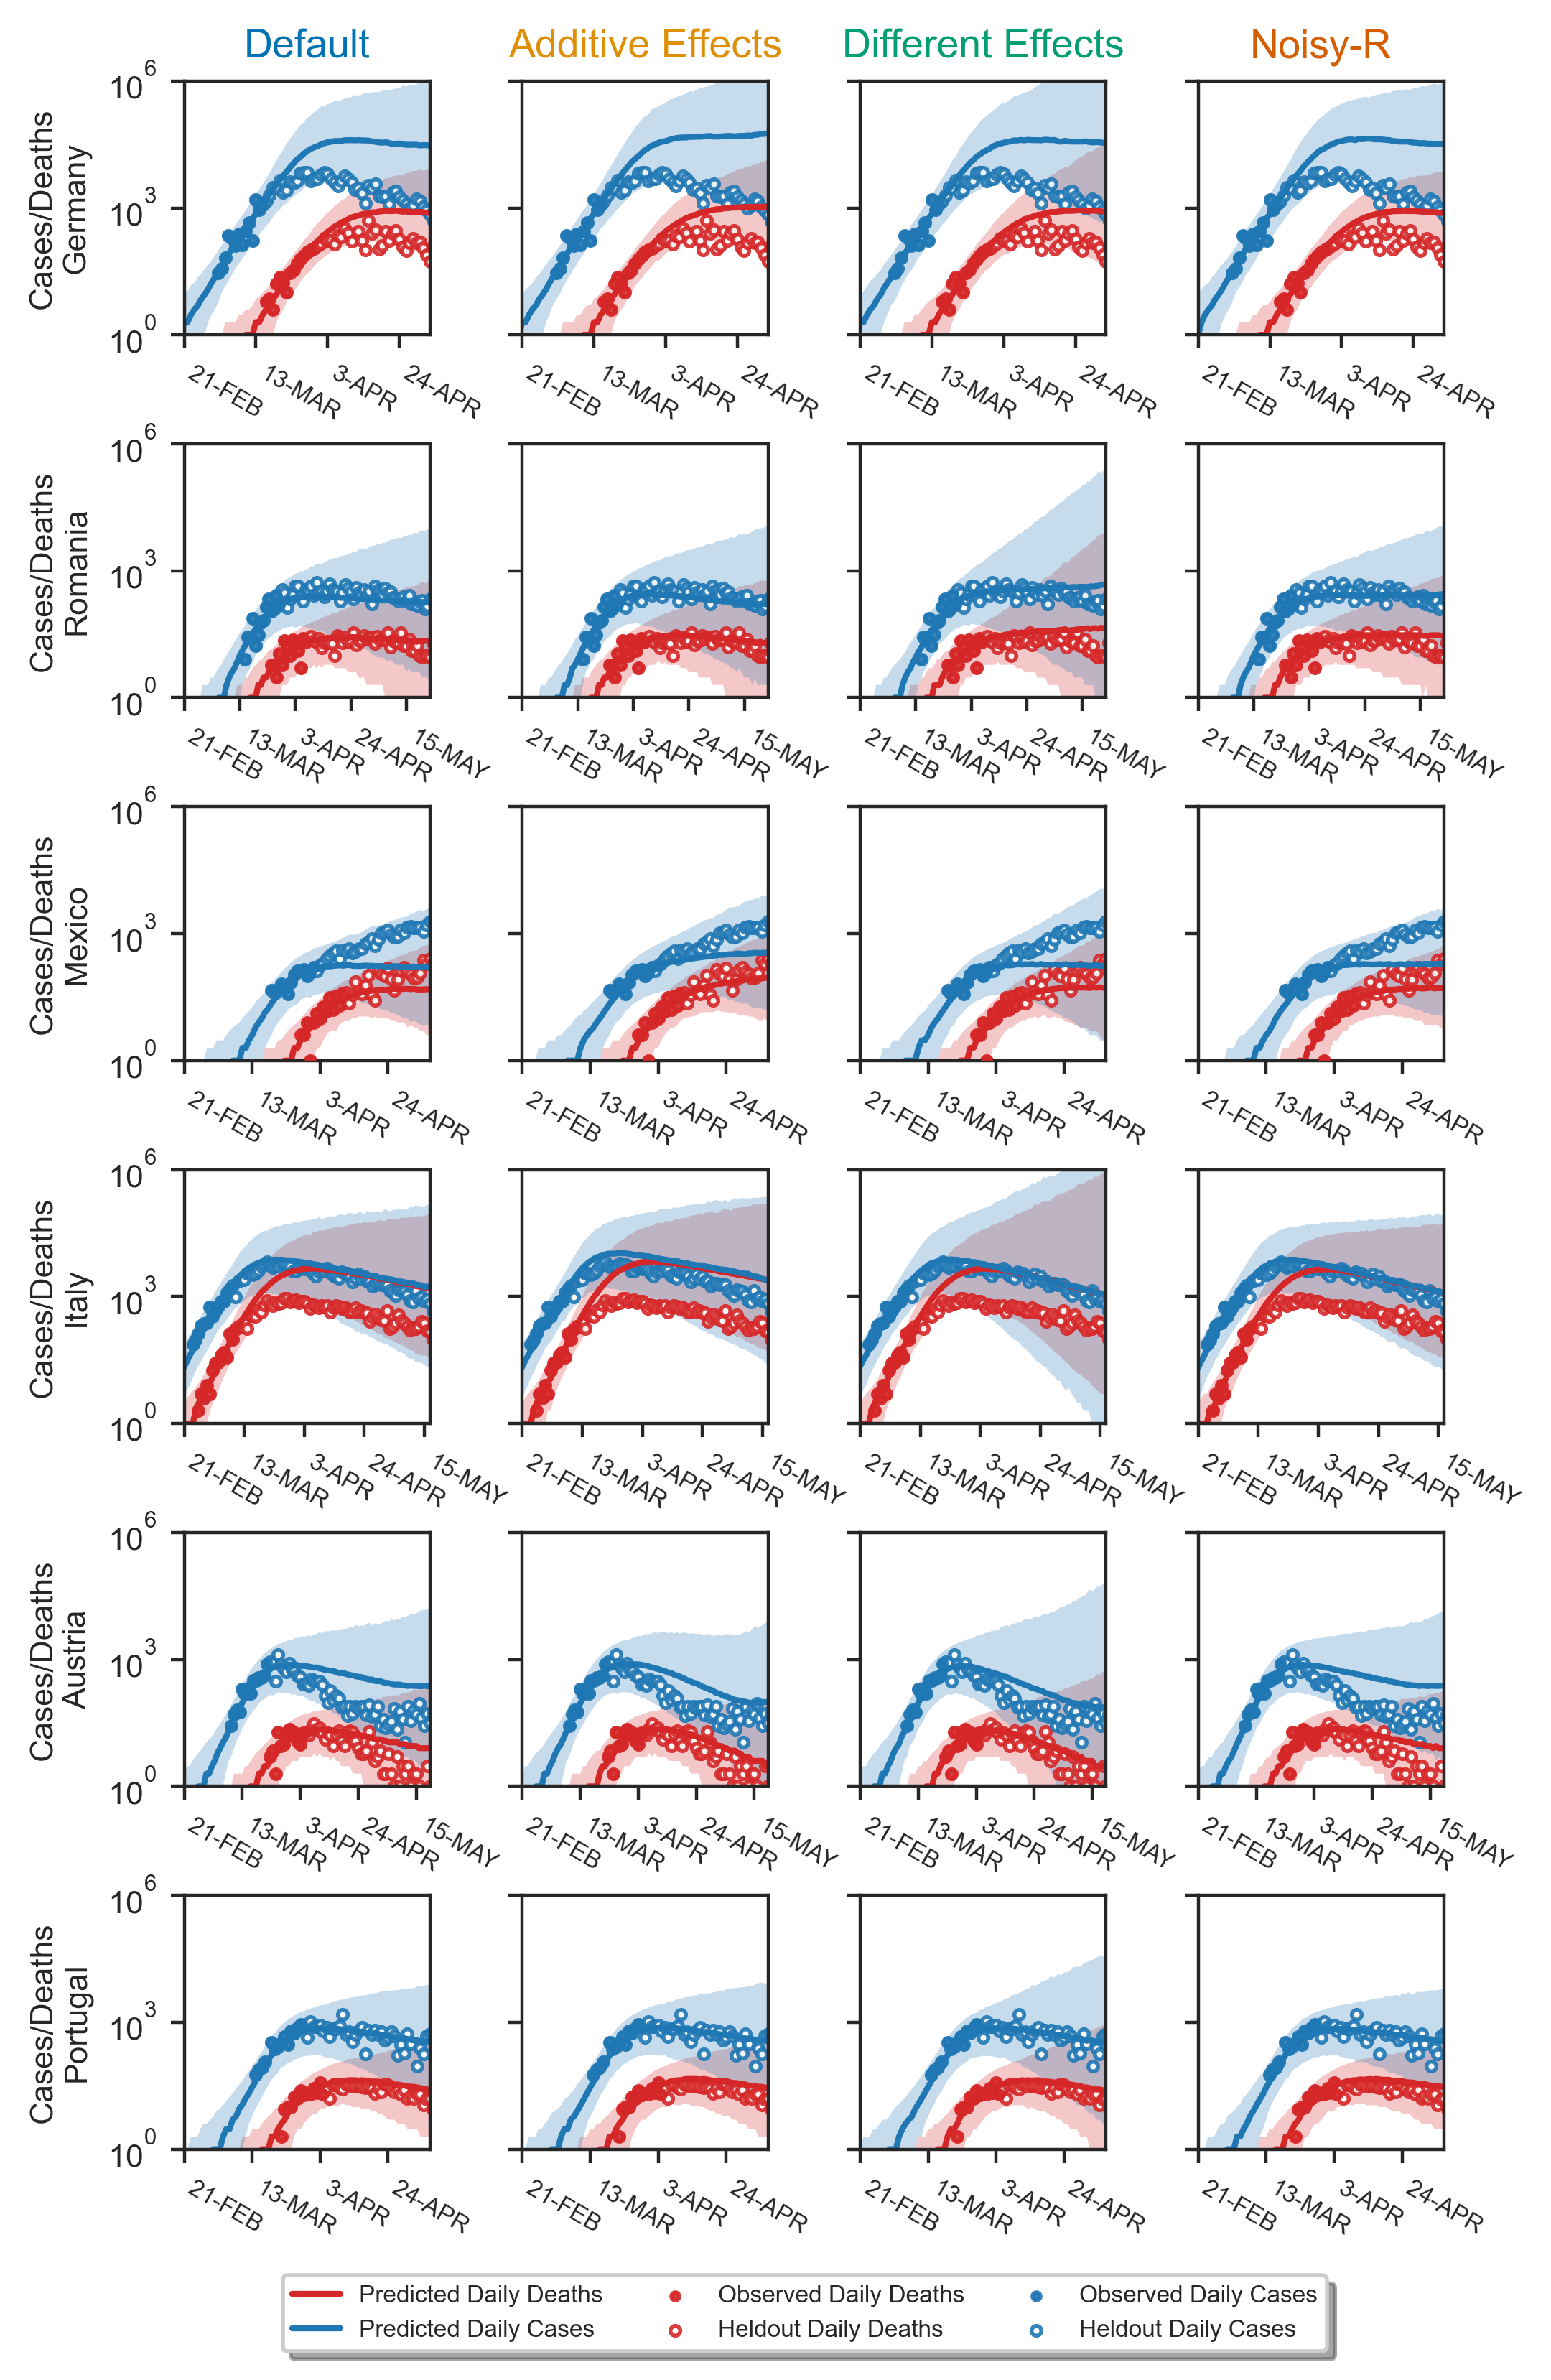

In [70]:
model_types = ['default', 'additive', 'diffeff', 'noisy_r', 'dr', 'deaths_dr', 'icl', 'default_nonoise']
model_names = ['Default', 'Additive Effects', 'Different Effects', 'Noisy-R', 'Discrete Renewal (DR)', 'Deaths-Only DR', 'Flaxman et al. [8]',  'Default\n(No Transmission Noise)']
mcols = sns.color_palette("colorblind")
regions = ['DE', 'RO', 'MX', 'IT', 'AT','PT']

model_info = list(zip(model_types, model_names, mcols))
base_dir='../../server_neurips2/'

plt.figure(figsize=(5.5, 8), dpi=400)

for m_i, (m_type, m_name, m_col) in enumerate(model_info[:4]):
    for r_i, rg in enumerate(regions):
        
        data.unmask_all()
        data.mask_reopenings(print_out=False)
        
        plt.subplot(6, 4, m_i + r_i*4 +1)
        
        start_d_i = 30 
        ax = plt.gca()

        if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
            end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]+3
        else:
            end_d_i = len(data.Ds)

        data.mask_region(rg)
        
        model_path = os.path.join(base_dir, m_type)

        ec = sample_cases_region(model_path, rg, data)
        ed = sample_deaths_region(model_path, rg, data)

        means_expected_deaths, lu_ed, up_ed, _, _ = produce_CIs(ed)
        means_expected_cases, lu_ec, up_ec, _, _= produce_CIs(ec)

        rd_i = data.Rs.index(rg)
        
        days = data.Ds
        days_x = np.arange(len(days))
        deaths = data.NewDeaths[rd_i, :]
        cases = data.NewCases[rd_i, :]

        ax = plt.gca()

        plt.plot(
            days_x,
            means_expected_deaths,
            label="Predicted Daily Deaths",
            zorder=2,
            color="tab:red"
        )

        plt.fill_between(
            days_x, lu_ed, up_ed, alpha=0.25, color="tab:red", linewidth=0
        )

        plt.scatter(
            days_x,
            deaths,
            label="Observed Daily Deaths",
            marker="o",
            s=4,
            color="tab:red",
            alpha=0.9,
            zorder=3,
        )

        plt.scatter(
            days_x,
            deaths.data,
            label="Heldout Daily Deaths",
            marker="o",
            s=6,
            edgecolor="tab:red",
            facecolor="white",
            linewidth=1,
            alpha=0.9,
            zorder=2,
        )

        plt.plot(
            days_x,
            means_expected_cases,
            label="Predicted Daily Cases",
            zorder=2,
            color="tab:blue"
        )

        plt.fill_between(
            days_x, lu_ec, up_ec, alpha=0.25, color="tab:blue", linewidth=0
        )

        plt.scatter(
            days_x,
            cases,
            label="Observed Daily Cases",
            marker="o",
            s=4,
            color="tab:blue",
            alpha=0.9,
            zorder=3,
        )

        plt.scatter(
            days_x,
            cases.data,
            label="Heldout Daily Cases",
            marker="o",
            s=6,
            edgecolor="tab:blue",
            facecolor="white",
            linewidth=1,
            alpha=0.9,
            zorder=2,
        )

        ax.set_yscale("log")
        plt.ylim([10 ** 0, 10 ** 6])
        locs = np.arange(start_d_i, end_d_i, 21)
        
        xlabels = [f"{data.Ds[ts].day}-{month_to_str(data.Ds[ts].month)}" for ts in locs]
        plt.xticks(locs, xlabels, rotation=-30, ha="left", fontsize=6)
        plt.xlim((start_d_i, end_d_i))
        
        if m_i == 0:
            plt.yticks(fontsize=8)
            plt.ylabel(f'Cases/Deaths\n{data.RNames[rg][0]}', fontsize=8)
        else:
            plt.yticks([1, 1000, 10**6], ["", "", ""])
            
        if r_i == 0:
            plt.title(m_name, color=m_col, fontsize=10)

plt.tight_layout(w_pad=0, h_pad=0)
plt.legend(loc='upper center', bbox_to_anchor=(-1.6, -0.45), fancybox=True, shadow=True, fontsize=6, ncol=3)
plt.savefig('holdouts_one.pdf', bbox_inches='tight')

'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'


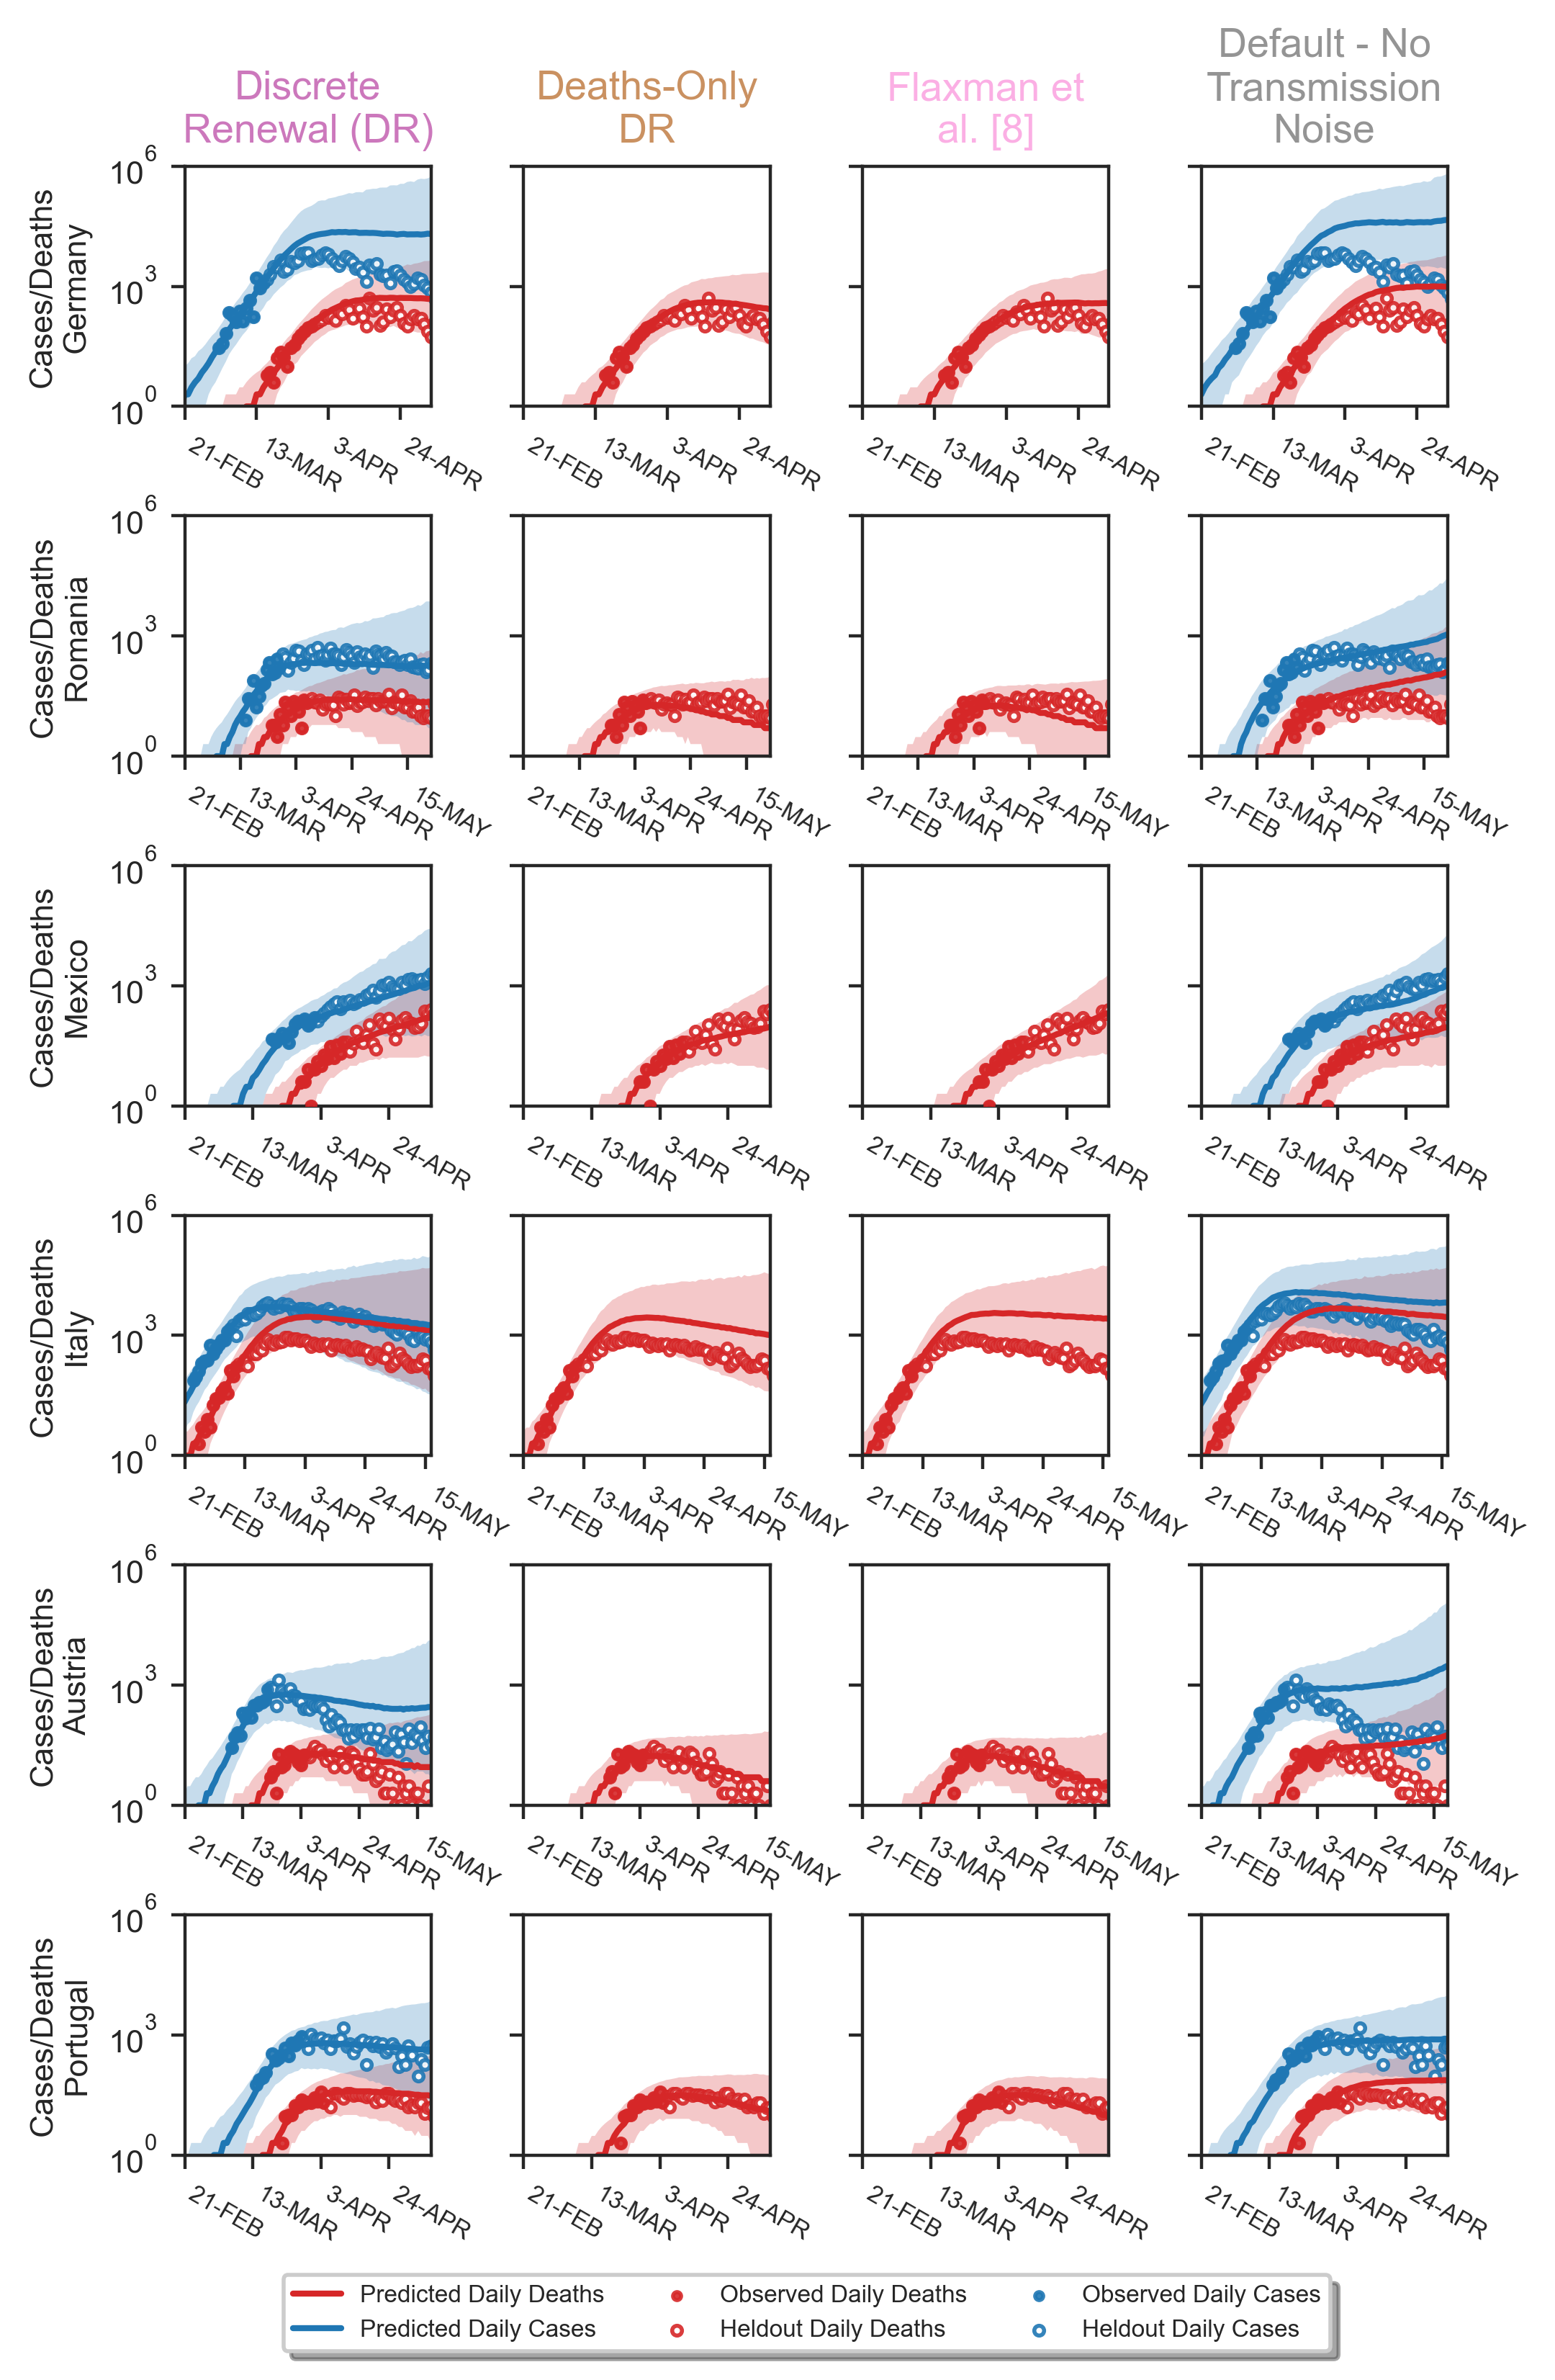

In [71]:
model_types = ['default', 'additive', 'diffeff', 'noisy_r', 'dr', 'deaths_dr', 'icl', 'default_nonoise']
model_names = ['Default', 'Additive Effects', 'Different Effects', 'Noisy-R', 'Discrete\nRenewal (DR)', 'Deaths-Only\nDR', 'Flaxman et\nal. [8]',  'Default - No\nTransmission\nNoise']
mcols = sns.color_palette("colorblind")
regions = ['DE', 'RO', 'MX', 'IT', 'AT','PT']
show_cases = [True, True, True, True, True, False, False, True]

model_info = list(zip(model_types, model_names, mcols, show_cases))
base_dir='../../server_neurips2/'

plt.figure(figsize=(5.5, 8), dpi=400)

for m_i, (m_type, m_name, m_col, sc) in enumerate(model_info[4:]):
    for r_i, rg in enumerate(regions):
        data.unmask_all()
        data.mask_reopenings(print_out=False)
        
        plt.subplot(6, 4, m_i + r_i*4 +1)
        
        start_d_i = 30 
        ax = plt.gca()

        if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
            end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]+3
        else:
            end_d_i = len(data.Ds)

        data.mask_region(rg)
        
        model_path = os.path.join(base_dir, m_type)

        ec = sample_cases_region(model_path, rg, data)
        ed = sample_deaths_region(model_path, rg, data)

        means_expected_deaths, lu_ed, up_ed, _, _ = produce_CIs(ed)
        means_expected_cases, lu_ec, up_ec, _, _= produce_CIs(ec)

        rd_i = data.Rs.index(rg)
        
        days = data.Ds
        days_x = np.arange(len(days))
        deaths = data.NewDeaths[rd_i, :]
        cases = data.NewCases[rd_i, :]

        ax = plt.gca()

        plt.plot(
            days_x,
            means_expected_deaths,
            label="Predicted Daily Deaths",
            zorder=2,
            color="tab:red"
        )

        plt.fill_between(
            days_x, lu_ed, up_ed, alpha=0.25, color="tab:red", linewidth=0
        )

        plt.scatter(
            days_x,
            deaths,
            label="Observed Daily Deaths",
            marker="o",
            s=4,
            color="tab:red",
            alpha=0.9,
            zorder=3,
        )

        plt.scatter(
            days_x,
            deaths.data,
            label="Heldout Daily Deaths",
            marker="o",
            s=6,
            edgecolor="tab:red",
            facecolor="white",
            linewidth=1,
            alpha=0.9,
            zorder=2,
        )
        
        if sc:
            plt.plot(
                days_x,
                means_expected_cases,
                label="Predicted Daily Cases",
                zorder=2,
                color="tab:blue"
            )

            plt.fill_between(
                days_x, lu_ec, up_ec, alpha=0.25, color="tab:blue", linewidth=0
            )

            plt.scatter(
                days_x,
                cases,
                label="Observed Daily Cases",
                marker="o",
                s=4,
                color="tab:blue",
                alpha=0.9,
                zorder=3,
            )

            plt.scatter(
                days_x,
                cases.data,
                label="Heldout Daily Cases",
                marker="o",
                s=6,
                edgecolor="tab:blue",
                facecolor="white",
                linewidth=1,
                alpha=0.9,
                zorder=2,
            )

        ax.set_yscale("log")
        plt.ylim([10 ** 0, 10 ** 6])
        locs = np.arange(start_d_i, end_d_i, 21)
        
        xlabels = [f"{data.Ds[ts].day}-{month_to_str(data.Ds[ts].month)}" for ts in locs]
        plt.xticks(locs, xlabels, rotation=-30, ha="left", fontsize=6)
        plt.xlim((start_d_i, end_d_i))
        
        if m_i == 0:
            plt.yticks(fontsize=8)
            plt.ylabel(f'Cases/Deaths\n{data.RNames[rg][0]}', fontsize=8)
        else:
            plt.yticks([1, 1000, 10**6], ["", "", ""])
            
        if r_i == 0:
            plt.title(m_name, color=m_col, fontsize=10)

plt.tight_layout(w_pad=0, h_pad=0)
plt.legend(loc='upper center', bbox_to_anchor=(-1.6, -0.45), fancybox=True, shadow=True, fontsize=6, ncol=3)
plt.savefig('holdouts_two.pdf', bbox_inches='tight')